# Using Papermill to Execute a Digital Elevation Model and store the result in an S3 bucket

See [RFC](https://www.notion.so/sensandworkspace/RFC-Geospatial-integrations-with-a-REPL-bd5d344487234fef85e5414300e417f4) for more detail

In [1]:
#papermill_description=imports

import json
import os
import geopandas as gpd
from io import StringIO
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
import numpy as np
from botocore.exceptions import NoCredentialsError
from requests.exceptions import HTTPError
from gis_utils.stac import initialize_stac_client, query_stac_api, process_dem_asset
from gis_utils.dataframe import get_bbox_from_geodf
import rasterio.plot
import logging
import sys


# Configure logging level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger(__name__)

# Set environment variable for AWS public datasets
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

In [2]:
#papermill_description=compute_elevation_statistics

def compute_elevation_statistics(dem_data):
    """
    Compute basic elevation statistics from a digital elevation model (DEM) dataset.

    This function calculates the minimum, maximum, mean, and standard deviation of elevation
    values within the provided DEM data array. It handles the DEM data as a NumPy array,
    which is a common format for raster data in Python.

    Parameters:
    - dem_data (numpy.ndarray): A 2D NumPy array containing elevation data from a DEM raster.
      The array should contain numeric values representing elevation at each cell. No-data
      values should be represented by NaNs in the array to be properly ignored in calculations.

    Returns:
    - dict: A dictionary containing the computed elevation statistics, with keys 'min_elevation',
      'max_elevation', 'mean_elevation', and 'std_dev_elevation'.
    """

    # Compute the minimum elevation, ignoring any NaN values which represent no-data cells
    min_elevation = float(np.nanmin(dem_data))

    # Compute the maximum elevation, ignoring any NaN values
    max_elevation = float(np.nanmax(dem_data))

    # Compute the mean elevation, ignoring any NaN values
    mean_elevation = float(np.nanmean(dem_data))

    # Compute the standard deviation of elevation, ignoring any NaN values
    std_dev_elevation = float(np.nanstd(dem_data))

    # Construct and return a dictionary containing the computed statistics
    stats = {
        'min_elevation': min_elevation,
        'max_elevation': max_elevation,
        'mean_elevation': mean_elevation,
        'std_dev_elevation': std_dev_elevation
    }

    return stats

In [3]:
#papermill_description=parameters

notebook_key = "localjupyter"
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}
propertyName = "test"
start_date = "2023-01-01"
end_date = "2023-03-01"


In [4]:
#papermill_description=process_variables

# Construct the filenames using propertyName
elevation_json_filename = f"/tmp/dem_{propertyName}_elevation_stats.json"
output_tiff_filename = f"/tmp/dem_{propertyName}.tiff"

In [5]:
#papermill_description=processing_s3
from aws_utils import S3Utils

# Load AWS credentials from environment variables
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
aws_default_region = 'us-east-1'
bucket_name = os.getenv('AWS_S3_BUCKET_NOTEBOOK_OUTPUT')

if aws_access_key_id and aws_secret_access_key:
    s3_client = S3Utils(
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        region_name=aws_default_region,
        s3_bucket=bucket_name,
        prefix=notebook_key
    )
else:
    # If AWS_ACCESS_KEY_ID is not set, assume the code is running in AWS Lambda
    # and credentials will be obtained automatically through the execution role
    s3_client = S3Utils(
        region_name=aws_default_region,
        s3_bucket=bucket_name,
        prefix=notebook_key
    )

In [6]:
#papermill_description=processing_file_io

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

In [7]:
#papermill_description=processing_bounding_box

# Get bounding box from GeoJSON
bbox = get_bbox_from_geodf(geojson_data)

In [8]:
#papermill_description=processing_stac_init

stac_url_dem = "https://explorer.sandbox.dea.ga.gov.au/stac/"
stac_url_rgb = "https://earth-search.aws.element84.com/v1"
collections_dem = ['ga_srtm_dem1sv1_0']
collections_rgb = ['sentinel-2-l2a']

# Initialize STAC clients
logger.info(f"Initializing STAC client for DEM with URL: {stac_url_dem} and collections: {collections_dem}")
client_dem = initialize_stac_client(stac_url_dem)
logger.info(f"Initializing STAC client for RGB with URL: {stac_url_rgb} and collections: {collections_rgb}")
client_rgb = initialize_stac_client(stac_url_rgb)


INFO:__main__:Initializing STAC client for DEM with URL: https://explorer.sandbox.dea.ga.gov.au/stac/ and collections: ['ga_srtm_dem1sv1_0']
INFO:gis_utils.stac:Initializing STAC client for URL: https://explorer.sandbox.dea.ga.gov.au/stac/
INFO:gis_utils.stac:STAC client initialized successfully
INFO:__main__:Initializing STAC client for RGB with URL: https://earth-search.aws.element84.com/v1 and collections: ['sentinel-2-l2a']
INFO:gis_utils.stac:Initializing STAC client for URL: https://earth-search.aws.element84.com/v1
INFO:gis_utils.stac:STAC client initialized successfully


In [9]:
#papermill_description=processing_stac_search

start_date = "2023-01-01"
end_date = "2023-03-01"

# Query STAC catalogs
items_dem = query_stac_api(client_dem, bbox, collections_dem, None, None)
items_rgb = query_stac_api(client_rgb, bbox, collections_rgb, start_date, end_date)

INFO:gis_utils.stac:Found 1 items
INFO:gis_utils.stac:Found 10 items


In [10]:
#papermill_description=processing_stac_assets

# Only want the dem asset
item = items_dem[0]
dem_asset = item.assets.get('dem')

# Fallback DEM URL
fallback_dem_href = 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'

In [11]:
#papermill_description=processing_stac_asset

data, metadata, src = process_dem_asset(dem_asset, bbox, output_tiff_filename)

INFO:gis_utils.stac:Opening DEM asset from: s3://dea-public-data/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif


INFO:gis_utils.stac:Written data to dem_test.tiff
INFO:gis_utils.stac:Read data size: 576504 bytes
INFO:gis_utils.stac:Output file size: 574292 bytes


<closed DatasetReader name='s3://dea-public-data/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif' mode='r'>


"File 'dem_test.tiff' uploaded successfully to 'localjupyter/dem_test.tiff' in bucket 'jenna-remote-sensing-sandbox'."

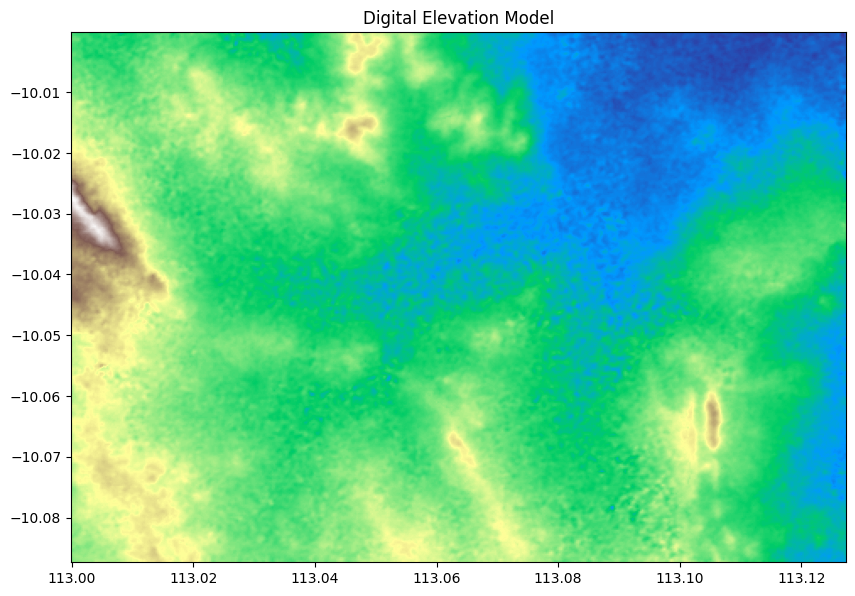

In [12]:
#papermill_description=processing

elevation_stats = compute_elevation_statistics(data)

# Plot the data using matplotlib
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(data, transform=src.transform, ax=ax, cmap='terrain')
ax.set_title('Digital Elevation Model')

# Serialize 'elevation_stats' to a JSON string
elevation_stats_json = json.dumps(elevation_stats)
# Convert the JSON string to bytes
elevation_stats_bytes = elevation_stats_json.encode()


s3_client.upload_file(file_path=output_tiff_filename, file_name=output_tiff_filename)


In [15]:
s3_client.list_files()



[{'file_name': 'jenna-remote-sensing-sandbox',
  'prefix': 'localjupyter',
  'key': 'localjupyter/dem_test.tiff'}]

In [19]:
s3_client.generate_presigned_urls()

TypeError: list indices must be integers or slices, not str